<function matplotlib.pyplot.show(close=None, block=None)>

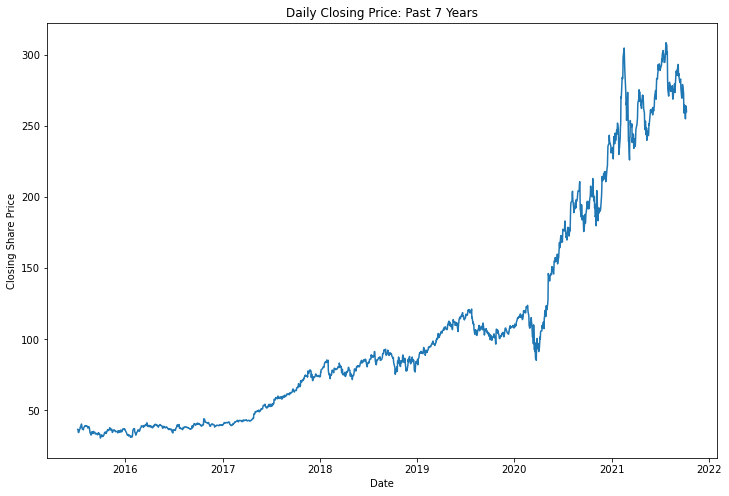

In [3]:

# imports datetime for picking beginning and end dates for the analysis
import datetime
# imports yahoo finance for getting historical stock prices
import yfinance as yf
# imports pandas for dataframe manipulation
import pandas as pd
# imports numpy
import numpy as np
# for data visualization
import matplotlib as mpl
# for changing the plot size in the Jupyter Notebook output
%matplotlib inline
# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)
# for shorter lines with plotting
from matplotlib import pyplot as plt
# to hide warning messages
import warnings
warnings.filterwarnings('ignore')

# sets the sample period as 5 years back from 09/12/2019
end = datetime.datetime(2021, 11, 10)
start = end - datetime.timedelta(days = 7*365)


# gets the closing price fo Netflix for the past 5 years
my_stock = yf.Ticker('PYPL')
my_stock = pd.DataFrame(my_stock.history(start = start, end = end)['Close'])
my_stock = my_stock.rename(str.lower, axis = 'columns')

# grabs the last 100 observations, which will be reduced to 50 for the purpose of fitting a
# distribution for Monte Carlo simulation
my_stock_resid_distr_fitting = my_stock[-500:]
# creates a training subset missing the final 100 observations, which are being withheld
my_stock_train = my_stock[~my_stock.isin(my_stock_resid_distr_fitting).all(1)]
# grabs the final 50 observations for a test set
my_stock_test = my_stock_resid_distr_fitting[-250:]
# reduces the distribution fitting dataset to 50 observations
my_stock_resid_distr_fitting = my_stock_resid_distr_fitting[~my_stock_resid_distr_fitting.isin(my_stock_test).all(1)]

# plots the my_stock weekly closing price over the past 5 years
plt.plot(my_stock.index, my_stock.close)
plt.title('Daily Closing Price: Past 7 Years')
plt.xlabel('Date')
plt.ylabel('Closing Share Price')
plt.show

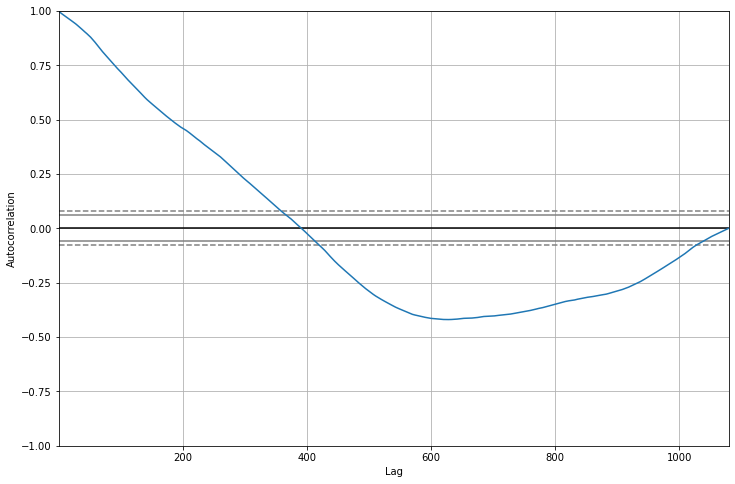

In [4]:
# to suppress warnings
warnings.filterwarnings('ignore')

# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)

# plots the ACF for the entire train period
pd.plotting.autocorrelation_plot(my_stock_train.close)
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

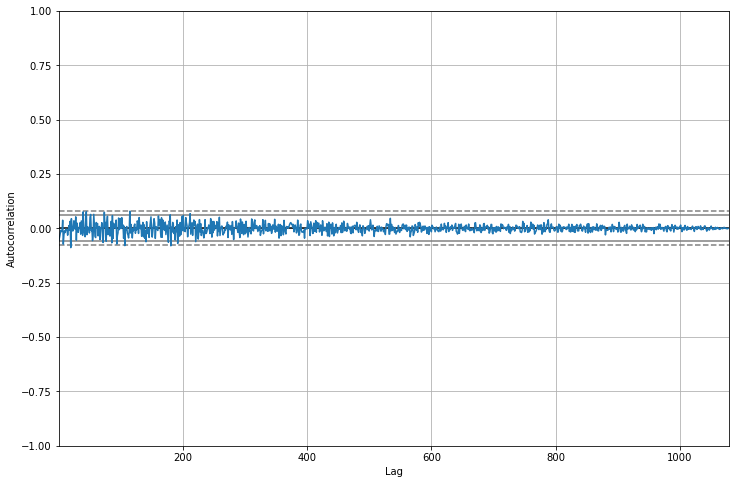

In [5]:
# to suppress warnings
warnings.filterwarnings('ignore')

# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)

# plots the ACF for the differenced data over the entire train period
pd.plotting.autocorrelation_plot(my_stock_train.close.diff().dropna())

In [6]:
# to suppress warnings
warnings.filterwarnings('ignore')

# imports the Augmented Dickey-Fuller Test for establishing the order of integration of 
# time series
from statsmodels.tsa.stattools import adfuller

# performs ADF tests with no constant, a constant, and a constant plus linear trend on
# NFLX closing share prices
for i in ['nc', 'c', 'ct']:
    result = adfuller(my_stock_train.close, regression = i)
    print('ADF Statistic with %s for Closing my_stock price: %f' % (i, result[0]))
    print('p-value: %f' % result[1])
    print('')

# performs ADF tests with no constant, a constant, and a constant plus linear trend on
# differenced NFLX closing share prices
for i in ['nc', 'c', 'ct']:
    result = adfuller(my_stock_train.close.diff().dropna(), regression = i)
    print('ADF Statistic with %s for Differenced Closing my_stock price: %f' % (i, result[0]))
    print('p-value: %f' % result[1])
    print('')

ADF Statistic with nc for Closing my_stock price: 1.560093
p-value: 0.970920

ADF Statistic with c for Closing my_stock price: -0.385755
p-value: 0.912450

ADF Statistic with ct for Closing my_stock price: -2.970757
p-value: 0.140441

ADF Statistic with nc for Differenced Closing my_stock price: -24.784359
p-value: 0.000000

ADF Statistic with c for Differenced Closing my_stock price: -24.880731
p-value: 0.000000

ADF Statistic with ct for Differenced Closing my_stock price: -24.874546
p-value: 0.000000



                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 1078
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2801.966
Method:                       css-mle   S.D. of innovations              0.018
Date:                Mon, 11 Oct 2021   AIC                          -5595.932
Time:                        11:58:21   BIC                          -5576.001
Sample:                             1   HQIC                         -5588.385
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0010      0.000      2.698      0.007       0.000       0.002
ar.L1.D.close     0.8842      0.049     18.174      0.000       0.789       0.980
ma.L1.D.close    -0.9245      0.039    -

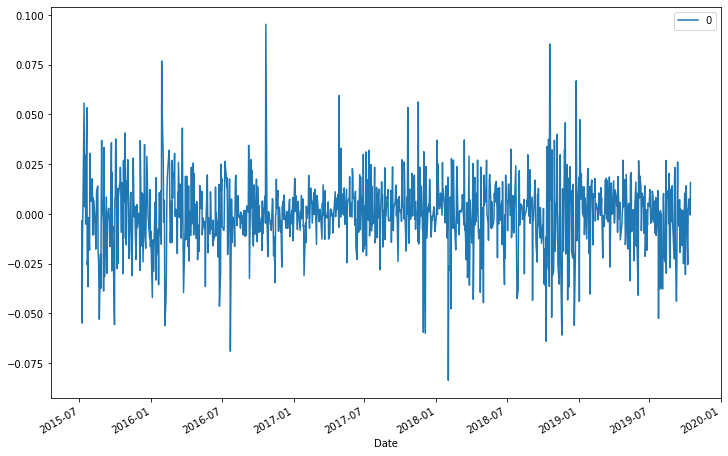

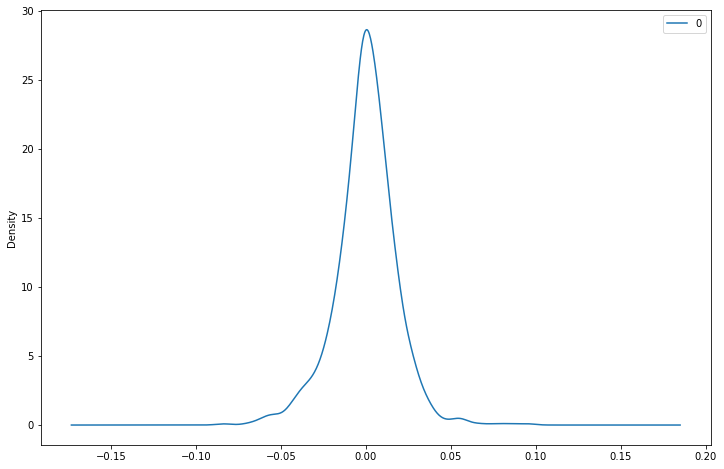

                 0
count  1078.000000
mean     -0.000002
std       0.017995
min      -0.083743
25%      -0.008844
50%       0.000316
75%       0.009726
max       0.095354


In [7]:
# to suppress warnings
warnings.filterwarnings('ignore')

# imports the ARIMA model
from statsmodels.tsa.arima_model import ARIMA

# fits the ARIMA model
my_stock_arima = ARIMA(np.log(my_stock_train.astype(float)), order = (1, 1, 1))
my_stock_arima_fit = my_stock_arima.fit(disp = 0)
print(my_stock_arima_fit.summary())

# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)

# plot residual errors of the training data
residuals = pd.DataFrame(my_stock_arima_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

Test MSE: 15.419


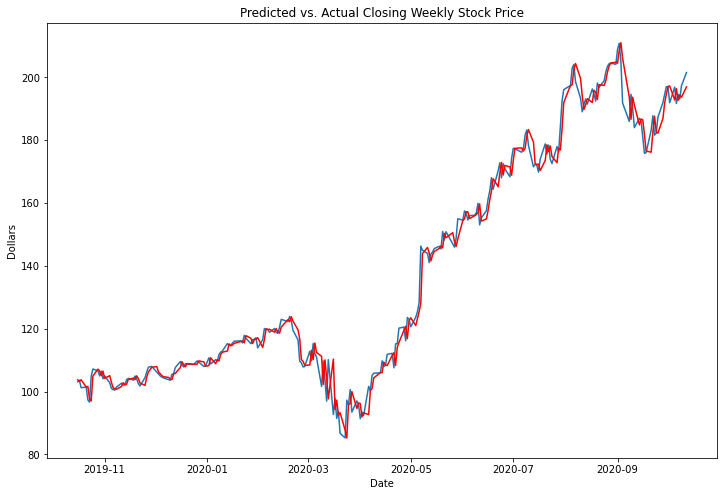

In [10]:

# to suppress warnings
warnings.filterwarnings('ignore')

# imports the mean squared error function
from sklearn.metrics import mean_squared_error

# from https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

# creates a new dataframe that will be added to as the forecast rolls 
history = np.log(my_stock_train.astype(float))
# creates an empty list that will hold predictions
predictions = []
# loops through the indexes of the set being forecased
for i in range(len(my_stock_resid_distr_fitting)):
    # estimates an ARIMA model of order (1,1,1)
    model = ARIMA(history, order = (1,1,1))
    # fits the model
    model_fit = model.fit(disp = 0)
    # forecasts the next period
    output = model_fit.forecast()
    # takes the predicted value and saves it in yhat
    yhat = np.e ** output[0]
    # appends yhat to the list of predictions
    predictions.append(yhat)
    # grabs the observation at the ith index
    obs = my_stock_resid_distr_fitting[i : i + 1]
    # appends the observation to the estimation data set
    history = history.append(np.log(obs.astype(float)))

# prints the MSE of the model for the rolling forecast period
error = mean_squared_error(my_stock_resid_distr_fitting, predictions)
print('Test MSE: %.3f' % error)

# converts the predictions list to a pandas dataframe with the same index as the actual values
# for plotting purposes
predictions = pd.DataFrame(predictions)
predictions.index = my_stock_resid_distr_fitting.index

# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)

# plots the predicted and actual stock prices 
plt.plot(my_stock_resid_distr_fitting)
plt.plot(predictions, color = 'red')
plt.xlabel('Date')
plt.ylabel('Dollars')
plt.title('Predicted vs. Actual Closing Weekly Stock Price')
plt.show()

<AxesSubplot:ylabel='Density'>

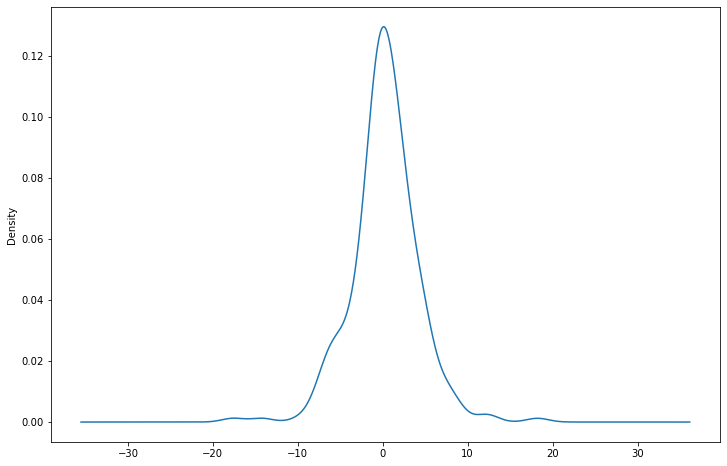

In [11]:
# to suppress warnings
warnings.filterwarnings('ignore')

# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)

# plots the residuals
tune_residuals = my_stock_resid_distr_fitting.close - predictions[0]
tune_residuals.plot(kind = 'kde')

In [12]:
# to suppress warnings
warnings.filterwarnings('ignore')

# produces a summary of the residuals
tune_residuals.astype(float).describe()

count    250.000000
mean       0.268208
std        3.925453
min      -17.611262
25%       -1.418108
50%        0.112584
75%        2.245494
max       18.219605
dtype: float64

In [14]:
# to suppress warnings
warnings.filterwarnings('ignore')

# imports the fitter function and produces estimated fits for our residuals
from fitter import Fitter

f = Fitter(tune_residuals)
f.fit()
f.summary

<bound method Fitter.summary of <fitter.fitter.Fitter object at 0x000002EBE1089D60>>

In [16]:

# creates a function to do MC simulation with a Laplacian distribution
def laplace_monte_carlo(mean, residuals, n_sims):
    # gets the estimated beta or mean absolute distance from the mean
    beta = (sum(abs(residuals - np.mean(residuals))) 
                           / len(residuals))
    # uses the numpy function to generate an array of simulated values
    est_range = np.random.laplace(mean, beta, n_sims)
    # converts the array to a list
    est_range = list(est_range)
    # returns the simulated values
    return(est_range)

def roll_forecast_nmc(train, test, std_dev, n_sims):
    # creates a new dataframe that will be added to as the forecast rolls 
    history = np.log(train.astype(float))
    # creates an empty list that will hold predictions
    predictions = []
    # loops through the indexes of the set being forecased
    for i in range(len(test)):
        # estimates an ARIMA model of order (1,1,0)
        model = ARIMA(history, order = (1,1,1))
        # fits the model
        model_fit = model.fit(disp = 0)
        # forecasts the next period
        output = model_fit.forecast()
        # takes the predicted value and saves it in yhat
        yhat = np.e ** output[0]
        # performs monte carlo simulation using the predicted price as the mean, user-specified
        # standard deviation, and number of simulations
        yhat_range = laplace_monte_carlo(yhat, std_dev, n_sims)
        # appends yhat_range to the list of predictions
        predictions.append([float(i) for i in yhat_range])
        # grabs the observation at the ith index
        obs = test[i : i + 1]
        # appends the observation to the estimation data set
        history = history.append(np.log(obs.astype(float)))

    # converts the predictions list to a pandas dataframe with the same index as the actual 
    # values for plotting purposes
    predictions = pd.DataFrame(predictions)
    predictions.index = my_stock_resid_distr_fitting.index
    # converts all the estimated yhats in each column to one list per row
    predictions['predicted_range'] = predictions.values.tolist()
    # grabs only the column with all values in a list
    predictions = pd.DataFrame(predictions['predicted_range'])
        
    # returns predictions
    return(predictions)

In [21]:
# attaches the data withheld for investigating the forecast residuals back to the training
# data set to avoid a large error on the first forecast
my_stock_train = my_stock_train.append(my_stock_resid_distr_fitting)


# produces a rolling forecast with prediction intervals using 1000 MC sims
test_preds = roll_forecast_nmc(my_stock_train, 
                               my_stock_test, 
                               tune_residuals,
                              10)

KeyboardInterrupt: 

In [20]:
# creates an empty list
in_prediction_interval = []
# loops through the rows in the testing data set
for i in range(len(my_stock_test)):
    # appends true if the actual price is in the interval of predicted prices and false
    # otherwise
    in_prediction_interval.append(np.where(min(test_preds.predicted_range[i]) <= 
                                           my_stock_test.close[i]
                                          <= max(test_preds.predicted_range[i]), 
                                           True, False))
# prints the percentage of actual prices in the prediction intervals    
print('Percentage of Actual Stock Prices in Predicted Stock Price Range: %f' % 
      (100 * sum(in_prediction_interval) / len(in_prediction_interval)))

NameError: name 'test_preds' is not defined

In [ ]:
# creates empty lists to append to with minimum and maximum values for each weeks prediction
min_range = []
max_range = []

# loops through the rows in test_preds
for i in range(len(test_preds)):
    # appends to the list the min or max value as appropriate
    min_range.append(min(test_preds.predicted_range[i]))
    max_range.append(max(test_preds.predicted_range[i]))

# converts the lists to data frames and makes their indexes match up with the dates they're
# predicting
min_range = pd.DataFrame(min_range)
min_range.index = my_stock_test.index
max_range = pd.DataFrame(max_range)
max_range.index = my_stock_test.index

# plots the actual stock price with prediction intervals
plt.plot(my_stock_test)
plt.plot(min_range, color = 'red')
plt.plot(max_range, color = 'red')
plt.xlabel('Date')
plt.ylabel('Dollars')
plt.title('Actual Closing Weekly Stock Price with Prediction Intervals')
plt.show()